In [1]:
import numpy as np
import pandas as pd
import scipy as scp 
from scipy.stats import multivariate_normal
import math
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.datasets

### Create Data for clustering

Simulate data from 5 different Gaussian distributions with different mean and covariance. Each of these distributions will be learnt and clustered separately using K-Means and EM-GMM

In [2]:
# Number of Dims (D) for X = 2

np.random.seed(42)

trg_1 = 0
trg_2 = 1
trg_3 = 2
trg_4 = 3
trg_5 = 4

sample_size_1 = 5000
sample_size_2 = 2000
sample_size_3 = 3000
sample_size_4 = 4000
sample_size_5 = 1000

In [3]:
# Samples with D = 2

c1 = np.repeat(0, sample_size_1)
c2 = np.repeat(1, sample_size_2)
c3 = np.repeat(2, sample_size_3)
c4 = np.repeat(3, sample_size_4)
c5 = np.repeat(4, sample_size_5)

samples_cluster_1 = np.random.multivariate_normal(mean=[1, 1], cov = sklearn.datasets.make_spd_matrix(2, random_state=None), size=sample_size_1)
samples_cluster_1 = np.hstack([samples_cluster_1, np.array([trg_1] * sample_size_1).reshape(sample_size_1, 1)])

samples_cluster_2 = np.random.multivariate_normal(mean=[-7, -4], cov = sklearn.datasets.make_spd_matrix(2, random_state=None), size=sample_size_2)
samples_cluster_2 = np.hstack([samples_cluster_2, np.array([trg_2] * sample_size_2).reshape(sample_size_2, 1)])

samples_cluster_3 = np.random.multivariate_normal(mean=[5, 6], cov = sklearn.datasets.make_spd_matrix(2, random_state=None), size=sample_size_3)
samples_cluster_3 = np.hstack([samples_cluster_3, np.array([trg_3] * sample_size_3).reshape(sample_size_3, 1)])

samples_cluster_4 = np.random.multivariate_normal(mean=[-6, 4], cov = sklearn.datasets.make_spd_matrix(2, random_state=None), size=sample_size_4)
samples_cluster_4 = np.hstack([samples_cluster_4, np.array([trg_4] * sample_size_4).reshape(sample_size_4, 1)])

samples_cluster_5 = np.random.multivariate_normal(mean=[2, -3], cov = sklearn.datasets.make_spd_matrix(2, random_state=None), size=sample_size_5)
samples_cluster_5 = np.hstack([samples_cluster_5, np.array([trg_5] * sample_size_5).reshape(sample_size_5, 1)])

Combine all the samples from the 5 distributions and shuffle. This will ensure input data sequence is random. 

In [4]:
X = np.vstack([samples_cluster_1, samples_cluster_2, samples_cluster_3, samples_cluster_4, samples_cluster_5])
C = np.concatenate([c1, c2, c3, c4, c5], axis=0)
random_state = np.random.get_state()

np.random.shuffle(X)
np.random.set_state(random_state)
np.random.shuffle(C)
X = np.delete(X, np.s_[-1:], axis=1)
np.savetxt("X.csv", X, delimiter=",")

In [5]:
print(X.shape)

(15000, 2)


### Plot

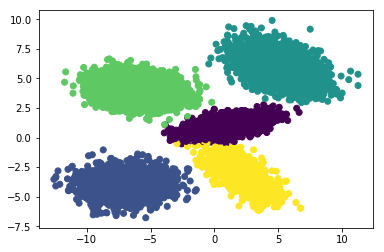

In [6]:
plt.scatter(X[:,0], X[:,1], c=C)

There are some clear visual patterns of the 5 clusters.

We will now learn these clusters using the following 2 models:
 * K-Means (Hard Clustering)
 * Gaussian Mixure Model (using EM method) 

## K-Means

Define KMeans two step process:
 * Assign each input sample to the nearest centroid
 * Recompute each centroid value based on new assigment of input samples

In [7]:
def KMeans_one_step(X, mu):
    C = []
    # Assignment step - assign each x to the nearest centroid. This means find ci for each xi.
    for x in X:
        l2 = []
        for mu_k in mu:
            l2.append(np.linalg.norm(x - mu_k)**2)
        C.append(np.argmin(l2))
    K, n_K = np.unique(C, return_counts=True)
    
    plt.scatter(X[:,0], X[:,1], c=np.array(C))
    plt.show()
    
    # Update step - Recalculate centroid for each cluster based on xi assignment toe cluster

    _mu = []
    for k, n_k in zip(K, n_K):
        mu_k = np.dot((C == k), X)/n_k
        _mu.append(mu_k)
    return _mu

## Coordinate Descent
Run coodinate descent algorithm for 10 iterations to optimize cluster centroids and assignments of input samples

Iteration  1


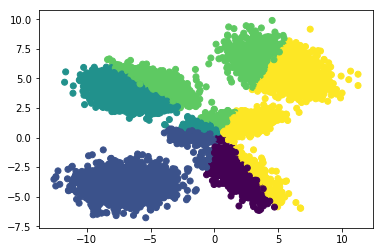

Iteration  2


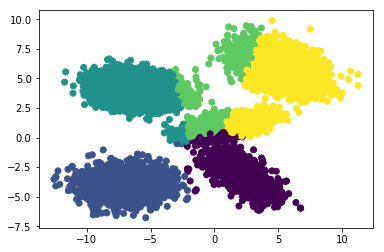

Iteration  3


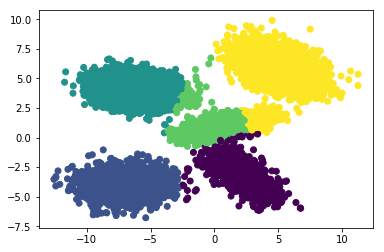

Iteration  4


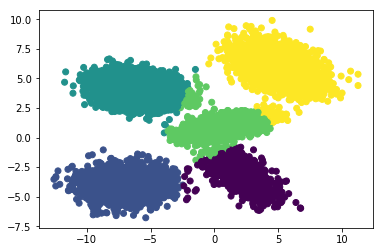

Iteration  5


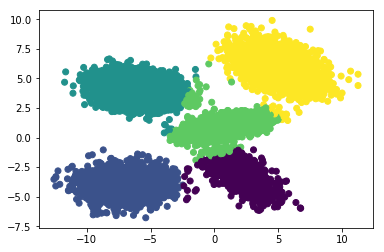

Iteration  6


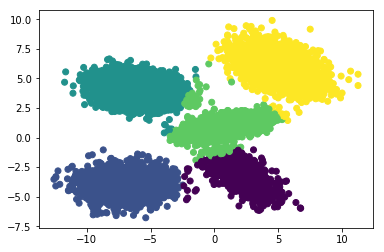

Iteration  7


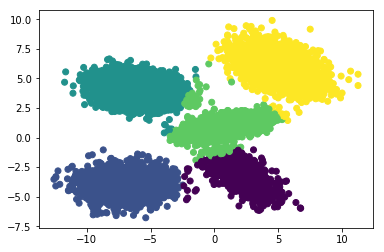

Iteration  8


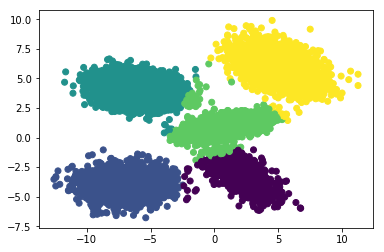

Iteration  9


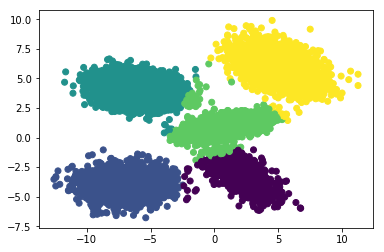

Iteration  10


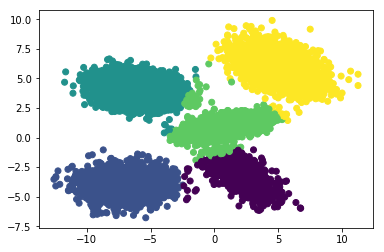

In [8]:
# Initialize the centroids randomly
mu = np.random.rand(5, X.shape[1])

# Calculate centroid for each cluster for 10 iterations
for ctr in range(10):
    print("Iteration ", ctr+1)
    mu = KMeans_one_step(X, mu)

## EM-GMM

Implement the soft clustering algorithm using EM-GMM 

In [9]:
def weighted_matrix(weight, matrix):
    weighted_matrix = []
    for i in range (weight.shape[0]):
        weighted_matrix.append(weight[i]*matrix)
    return np.array(weighted_matrix)

In [10]:
def calc_mean(X, phi, n_k):
    phi_x = 0
    for i in range(X.shape[0]):
        phi_x = phi_x + weighted_matrix(phi[i], X[i])
    return list(phi_x/np.array(n_k.reshape(len(n_k), 1)))


In [11]:
def calc_covariance(X, phi, mu, n_k):
    phi_covariance = []
    for k in (range(len(mu))):
        cov_k = 0
        for i in range(X.shape[0]):
            mean_dev = np.array((X[i] - mu[k]).reshape(len(X[i] - mu[k]), 1))
            cov_k = cov_k + np.dot(mean_dev, mean_dev.T)*phi[i][k]/n_k[k]
        phi_covariance.append(cov_k)
    return phi_covariance

In [12]:
def EMGMM_one_step(X, pi, mu, sigma):
    # E-Step - calculate weightage (phi) on each cluster using Gaussian probablity distribution
    phi = []
    posterior = []
    for x in X:
        posterior_k = []
        for k in range(len(pi)):
            mean_dev = x - mu[k]
            coefficient = 1/np.sqrt(((2*np.math.pi)**X.shape[1])*np.linalg.det(sigma[k]))
            mahalanobis_distance = mean_dev.T@np.linalg.inv(sigma[k])@mean_dev

            pdf_k = coefficient*np.exp(-0.5*mahalanobis_distance)
            posterior_k.append(pdf_k*pi[k])
        posterior.append(posterior_k)
        phi.append(posterior_k/np.asarray(posterior_k).sum())
    
    # M-Step - update pi, mu and sigma for each cluster
    n_k = np.array(phi).sum(axis=0)

    _pi = n_k/X.shape[0]
    _mu = calc_mean(X, np.array(phi), n_k)
    _sigma = calc_covariance(X, phi, mu, n_k)
    
    return (_pi, _mu, _sigma)

In [13]:
# Initialize parameters
pi = list(np.random.uniform(size=5))
mu = list(np.random.rand(5, X.shape[1]))
sigma = list([np.identity(X.shape[1])]*5)

# Calculate prior, centroid, covariance for each cluster for 10 iterations
for ctr in range(10):
    print("********************")
    print("Iteration ", ctr+1)
    print("********************")
    (pi, mu, sigma) = EMGMM_one_step(X, pi, mu, sigma)
    print("pi", pi)
    print("______________________")
    print("mu", mu)
    print("______________________")
    print("sigma", sigma)

********************
Iteration  1
********************
pi [0.29216934 0.14910307 0.44878172 0.07752947 0.03241641]
______________________
mu [array([-3.15244597, -1.1487216 ]), array([2.69979504, 0.8333883 ]), array([-1.67986662,  3.8364756 ]), array([3.68901384, 3.15699468]), array([-2.59548778,  3.39974408])]
______________________
sigma [array([[28.48279295, 11.43182671],
       [11.43182671, 10.8185676 ]]), array([[9.56879329, 4.87339215],
       [4.87339215, 9.98758981]]), array([[26.65152614, -2.8789692 ],
       [-2.8789692 , 13.36783491]]), array([[15.93081478, 13.09452661],
       [13.09452661, 14.92746743]]), array([[28.03041458, -5.8747067 ],
       [-5.8747067 , 11.59105808]])]
********************
Iteration  2
********************
pi [0.2692481  0.15568169 0.44341756 0.09725453 0.03439813]
______________________
mu [array([-2.69759884, -0.97326612]), array([2.46359515, 1.46296173]), array([-2.11438881,  3.32760659]), array([3.26478327, 3.26523513]), array([-3.13080981,  3.